In [1]:
%load_ext autoreload
%autoreload 2

In [174]:
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    MIN_VALUE_THRESHOLD,
    NAN_THRESHOLD,
    AdjacencyMethod,
    GraphEvent,
    Normalizer,
    load_events,
    setup_plotting,
)

setup_plotting()

In [128]:
events = load_events()

## Preprocess DataFrames

Somes events have 2-min resolution (we download them for 1-min though), so we decided to standardize all events to 2-min. And, apparently, the data cannot have any NaN value

In [129]:
def invalid_stations(station_df: pd.DataFrame, use_threshold: bool) -> List[str]:
    """Check if a station has less than NAN_THRESHOLD percentage of NaN values."""
    nan_ratios = station_df.isna().mean()

    if use_threshold:
        invalid_stations = nan_ratios[nan_ratios >= NAN_THRESHOLD].index.tolist()
    else:
        invalid_stations = nan_ratios[nan_ratios > 0].index.tolist()

    return invalid_stations

In [130]:
# Fill data preprocessing
for event_name, data in events.items():
    df = data["raw"]

    # Drop stations with too many NaNs
    stations_to_drop = invalid_stations(df, use_threshold=False)
    df = df.drop(columns=stations_to_drop)

    # Resample to 2-minute intervals using median
    events[event_name]["raw"] = df.resample("2min").median()

## Create Graphs & Compare normalization methods

Based on [001_tests_with_graphs.ipynb](./001_tests_with_graphs.ipynb), the best methods are: `MANHATTAN` & `MINKOWSKI`, so I'll be using only those. The data will be previously normalized with diferents methods in order to compare.

A new kind of graph is calculated, the "count" is not used to construct the adjacency matrix, now the matrix is calculated using the percentual change: $x_{i\%} = \frac{x_{i} - x_{i-1}}{x_{i-1}}$. When $i = 0$, $x_{i\%} = 0$; when $x_{i-1} = 0$, is replaced to `MIN_VALUE_THRESHOLD` (1e-16) 

In [131]:
valid_methods = (AdjacencyMethod.MANHATTAN, AdjacencyMethod.MINKOWSKI)

In [171]:
dataset = []

# 4 nested loops... damn
for event_date, data in events.items():
    for method in valid_methods:
        for normalization in Normalizer:
            raw_df = data["raw"].reset_index(drop=True)

            # Normalize data
            columns = raw_df.columns
            normalized_data = normalization.normalize(raw_df.to_numpy())
            normalized_df = pd.DataFrame(normalized_data, columns=columns)

            # Replace all zeros with a small value to avoid issues in pct_change (infinite values)
            normalized_df[normalized_df.abs() < MIN_VALUE_THRESHOLD] = (
                MIN_VALUE_THRESHOLD
            )

            # New DF using percentual change
            pct_change_df = normalized_df.pct_change().fillna(0)

            # Generate graph
            for df, label in ((normalized_df, "normal"), (pct_change_df, "pct_change")):
                graph_event = GraphEvent(
                    data=df,
                    metadata={"cutoff_rigidity": data["cutoff_rigidity"]},
                )
                graph = graph_event.get_graph_networkx(method)

                # Calculate MST and store it
                graph = nx.minimum_spanning_tree(graph)
                events[event_date]["graphs"][method] = graph

                # Global graph metrics
                dataset.append(
                    {
                        "event_date": event_date,
                        "intensity": data["intensity"],
                        "normalization": normalization.value,
                        "adjacency_method": method.value,
                        "data_label": label,
                        "graph": graph,
                        "diameter": (
                            nx.diameter(graph)
                            if nx.is_connected(graph)
                            else float("inf")
                        ),
                        "radius": (
                            nx.radius(graph) if nx.is_connected(graph) else float("inf")
                        ),
                        "global_efficiency": nx.global_efficiency(graph),
                        "average_clustering": nx.average_clustering(graph),
                        "transitivity": nx.transitivity(graph),
                        "connectivity": nx.number_connected_components(graph),
                        "modularity": nx.algorithms.community.modularity(
                            graph,
                            list(
                                nx.algorithms.community.greedy_modularity_communities(
                                    graph
                                )
                            ),
                        ),
                        "assortativity": nx.degree_assortativity_coefficient(graph),
                    }
                )

dataset_df = pd.DataFrame(dataset)

### Plot global metrics

In [150]:
metrics_columns = [
    "diameter",
    "radius",
    "global_efficiency",
    "average_clustering",
    "transitivity",
    "connectivity",
    "modularity",
    "assortativity",
]
id_vars = ["event_date", "intensity", "adjacency_method", "normalization", "data_label"]

dataset_copy_df = pd.DataFrame(dataset).drop(columns=["graph"])
plot_dataset_df = dataset_copy_df.melt(
    id_vars=id_vars,
    value_vars=metrics_columns,
    var_name="metric",
    value_name="value",
)

In [148]:
def plot_global_metrics_result(plot_dataset_df: pd.DataFrame, fig_title: str = "") -> None:
    unique_events = plot_dataset_df["event_date"].unique()
    normalization_methods = plot_dataset_df["normalization"].unique()

    nrows = len(unique_events)
    ncols = len(normalization_methods)

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(26, 12),
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for norm_method in normalization_methods:
            plot_data = plot_dataset_df[
                (plot_dataset_df["event_date"] == event_date)
                & (plot_dataset_df["normalization"] == norm_method)
            ]

            intensity = plot_data["intensity"].values[0]

            ax = axes[i]
            i += 1
            sns.barplot(
                data=plot_data,
                x="metric",
                y="value",
                hue="adjacency_method",
                ax=ax,
            )

            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt="%.2f", color="black", fontsize=8)

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} --"
                    f"\n Norm: {norm_method}"
                )
            )
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    if fig_title:
        fig.suptitle(fig_title, fontsize=16)

    fig.tight_layout()
    plt.show()


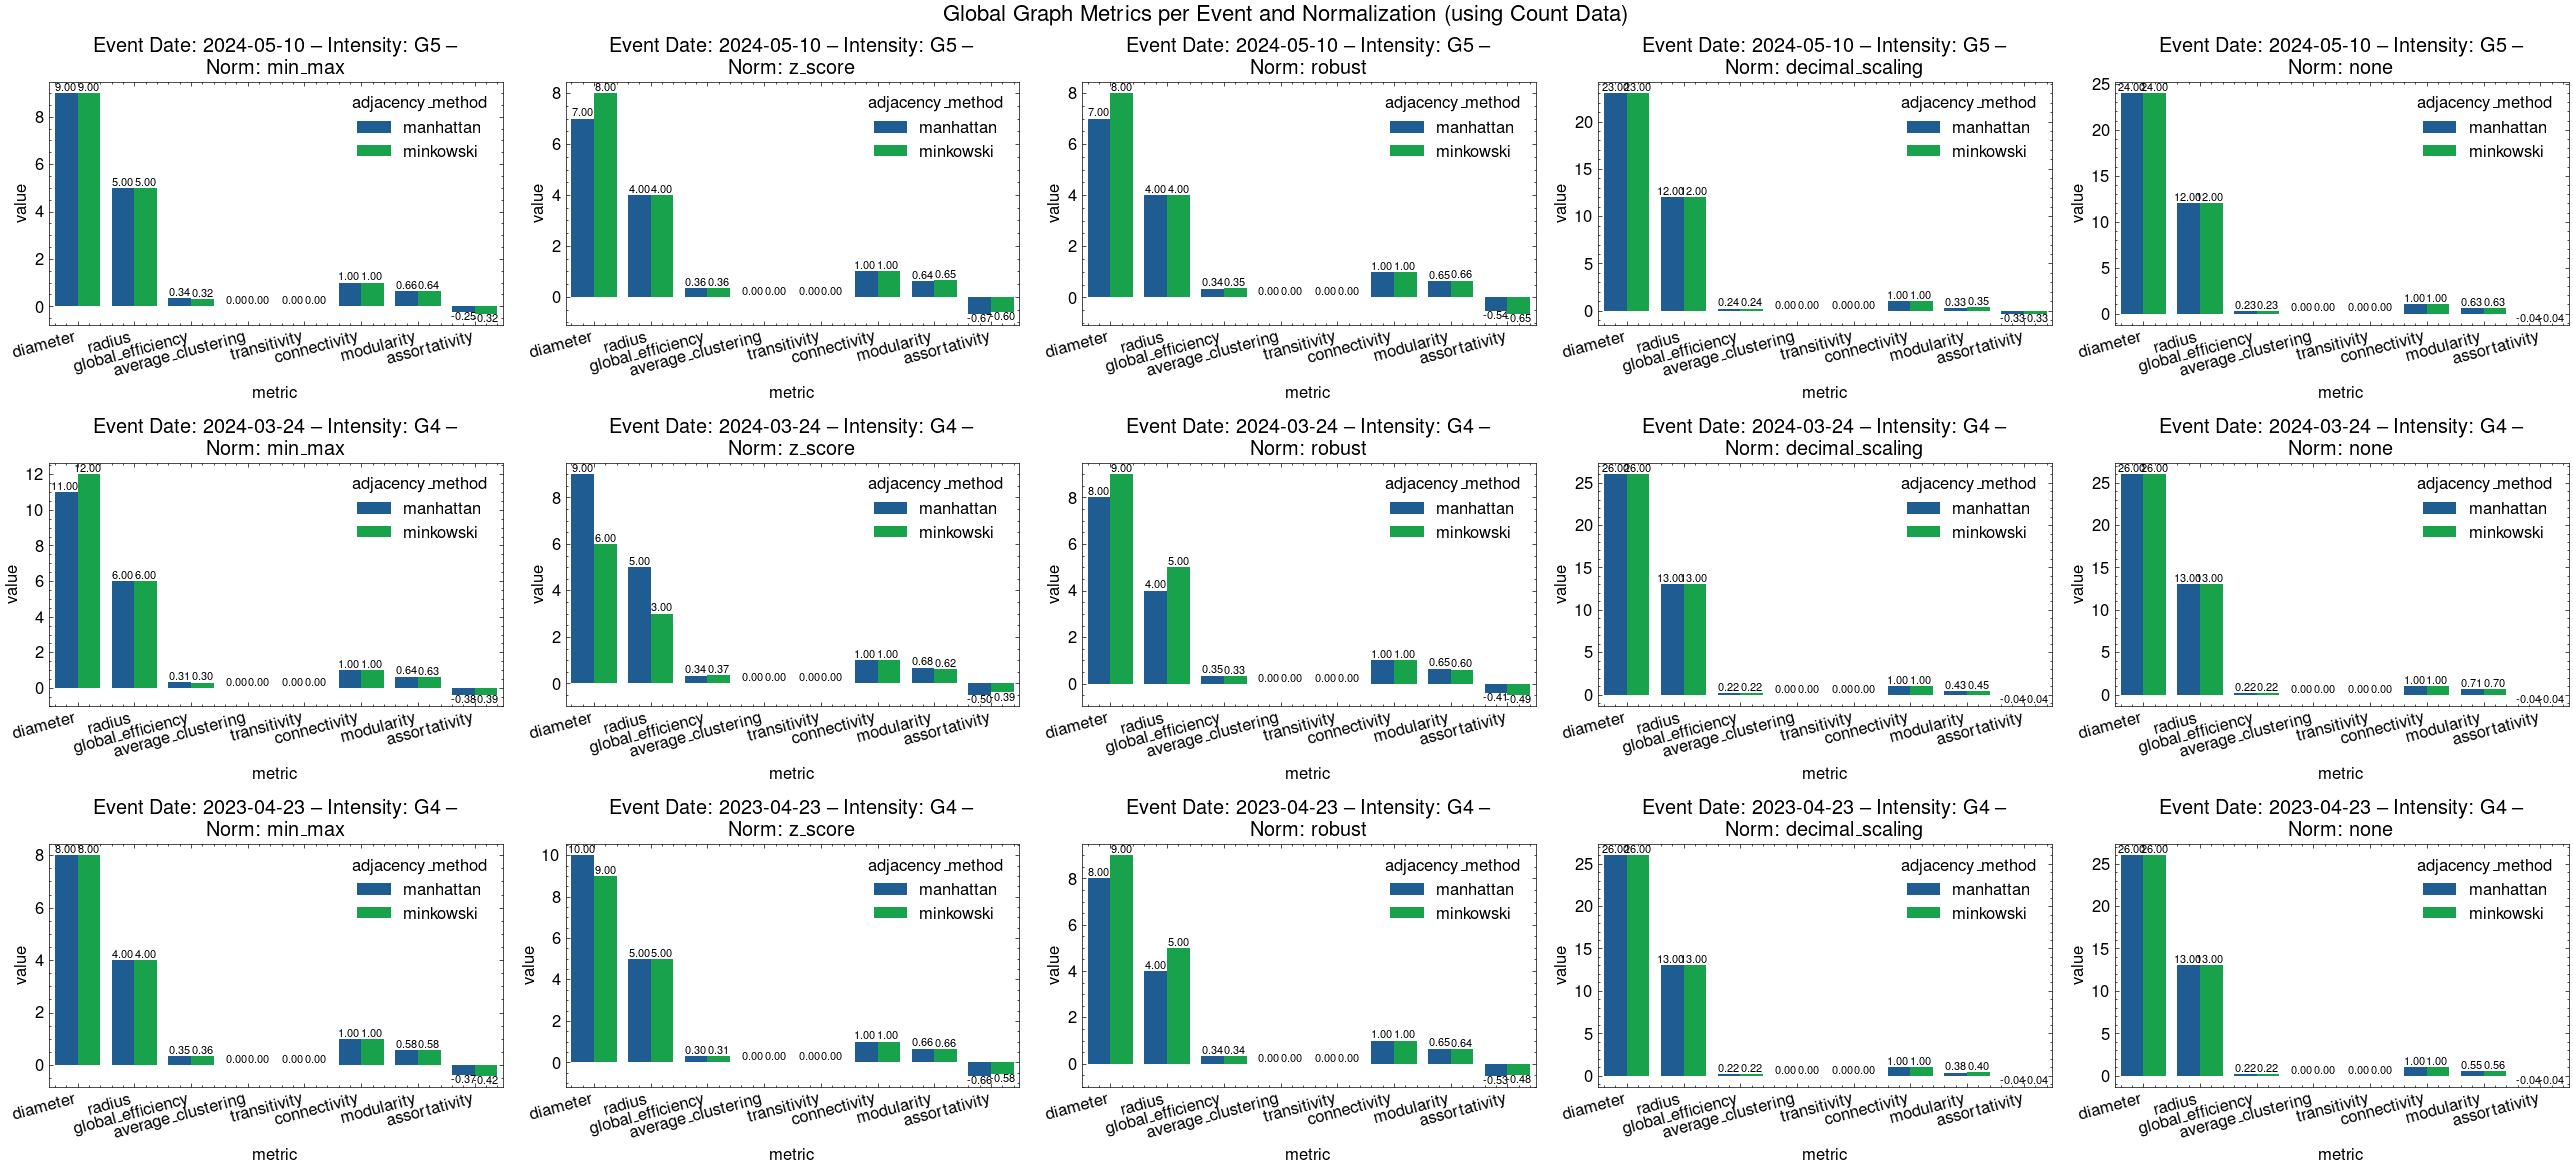

In [155]:
plot_global_metrics_result(
    plot_dataset_df[plot_dataset_df["data_label"] == "normal"],
    fig_title="Global Graph Metrics per Event and Normalization (using Count Data)",
)

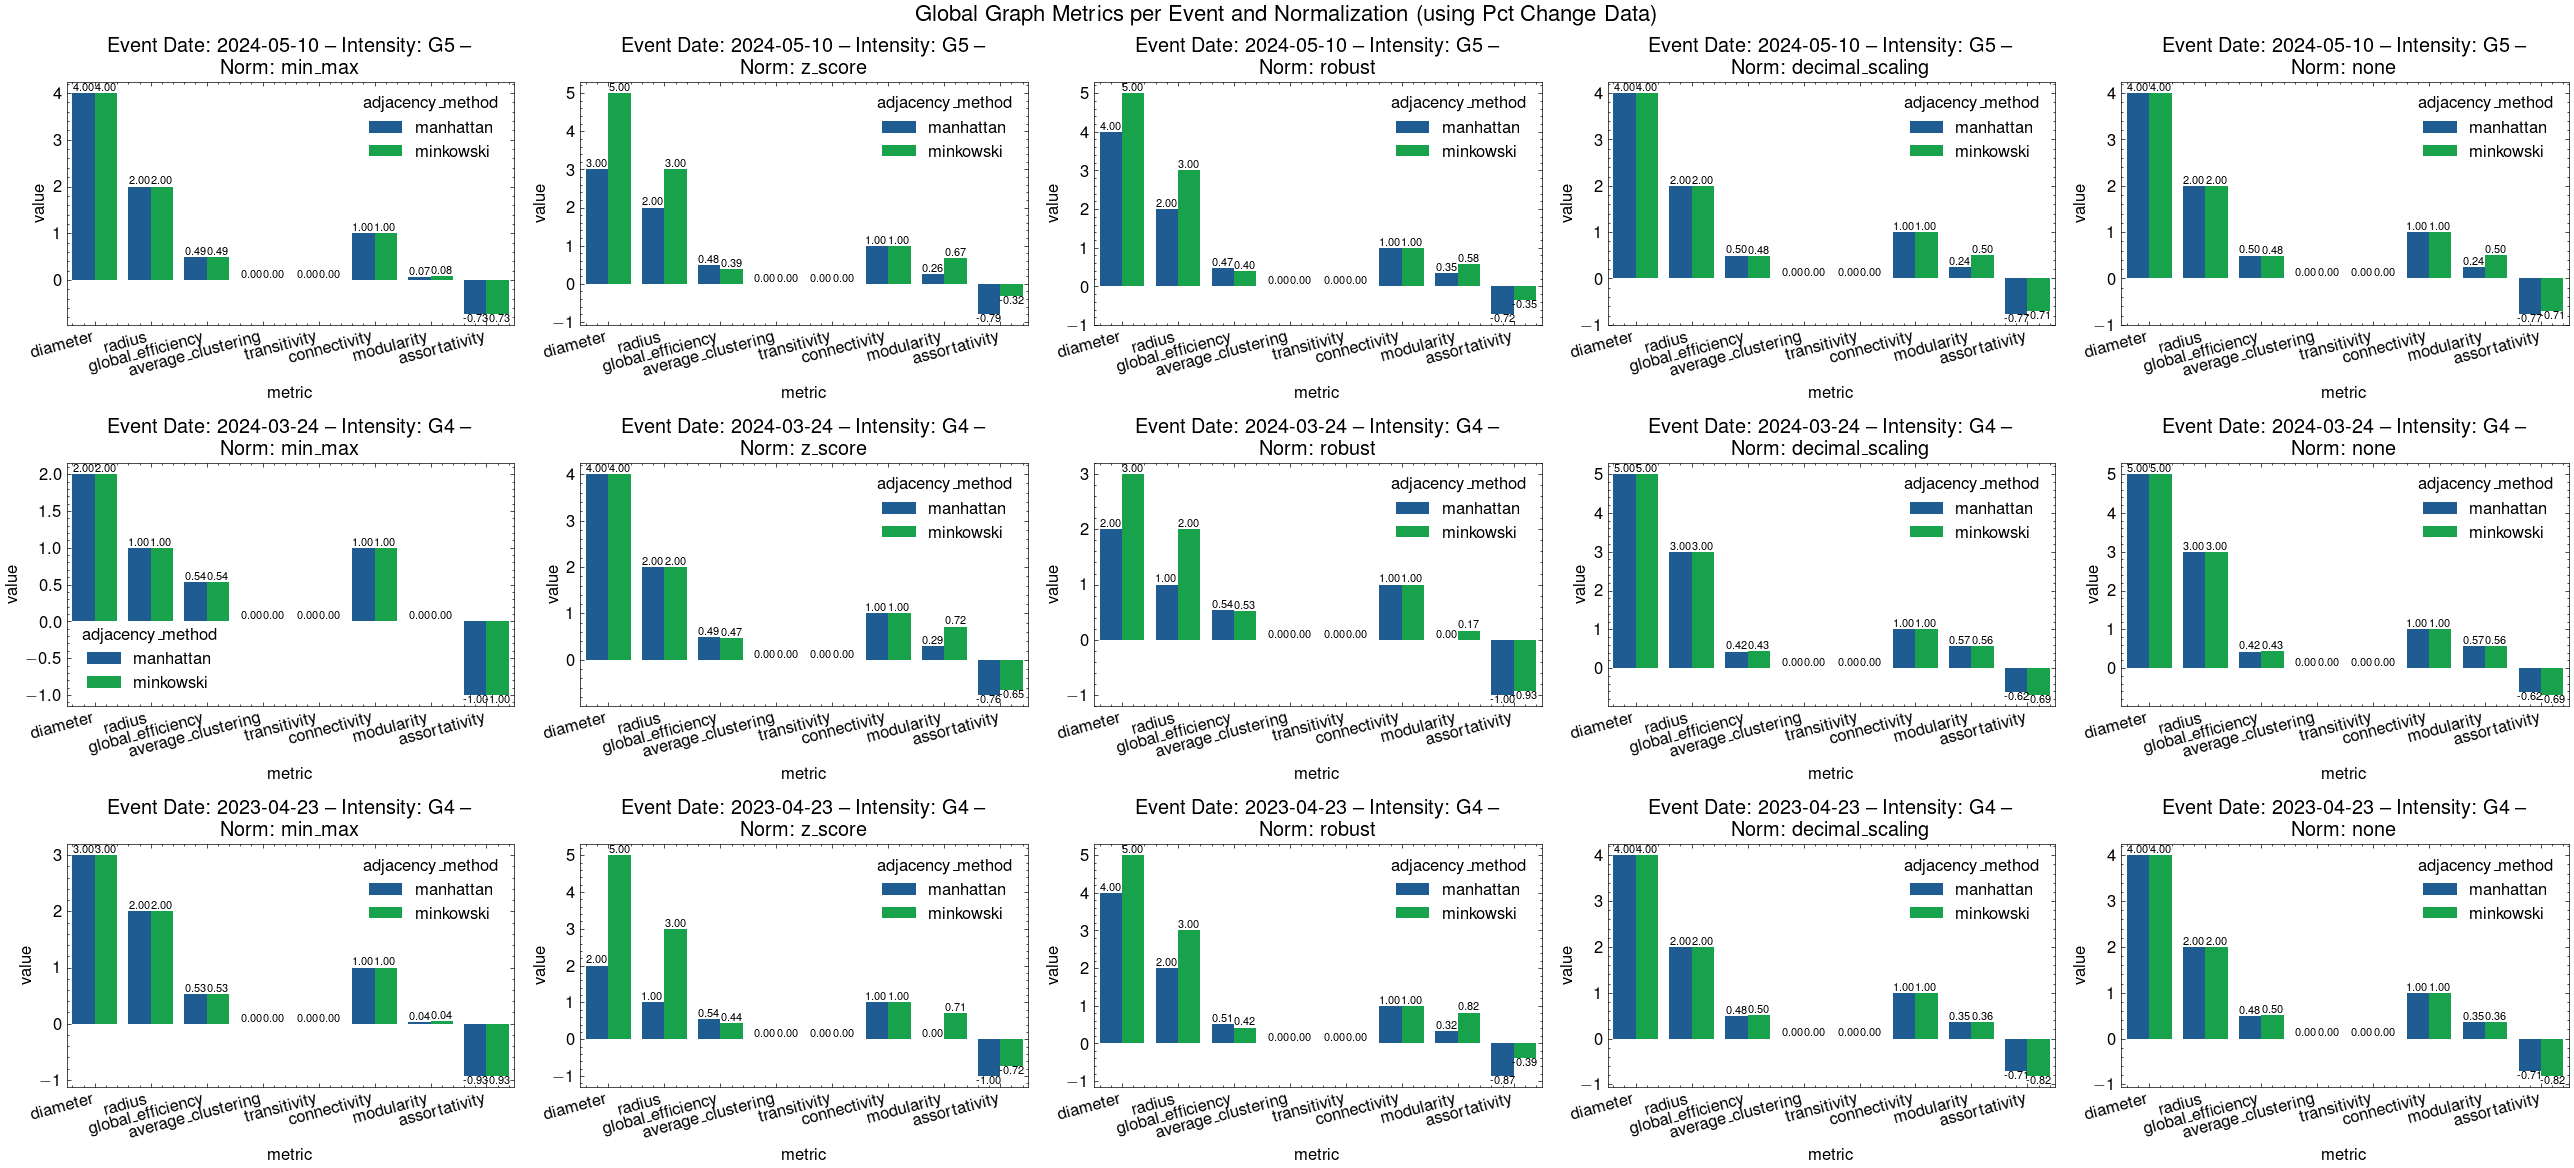

In [156]:
plot_global_metrics_result(
    plot_dataset_df[plot_dataset_df["data_label"] == "pct_change"],
    fig_title="Global Graph Metrics per Event and Normalization (using Pct Change Data)",
)

In [161]:
dataset_df.columns

Index(['event_date', 'intensity', 'normalization', 'adjacency_method',
       'data_label', 'graph', 'diameter', 'radius', 'global_efficiency',
       'average_clustering', 'transitivity', 'connectivity', 'modularity',
       'assortativity'],
      dtype='str')

### Plot graphs

I'm using only Z-Score, but it's just an example, could be interchangeable

In [198]:
def plot_graphs_result(df: pd.DataFrame, title: str = "") -> None:
    cmap = plt.cm.viridis  # type: ignore

    unique_events = df["event_date"].unique()
    adjacency_methods = df["adjacency_method"].unique()

    nrows = len(unique_events)
    ncols = len(adjacency_methods)

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(21, 12),
    )

    axes = axes.flatten()
    i = 0
    for event_date in unique_events:
        for adj_method in adjacency_methods:
            plot_data = df[
                (df["event_date"] == event_date)
                & (df["adjacency_method"] == adj_method)
            ]

            intensity = plot_data["intensity"].values[0]
            graph = plot_data["graph"].values[0]
            cutoff = graph.graph["metadata_cutoff_rigidity"]

            ax = axes[i]
            i += 1

            pos = nx.spring_layout(graph, weight="weight", seed=42)
            nodes = list(graph.nodes())
            vals = np.array([cutoff.get(n, np.nan) for n in nodes], dtype=float)

            if np.all(np.isnan(vals)):
                nx.draw(
                    graph,
                    pos,
                    ax=ax,
                    with_labels=True,
                    node_size=300,
                    font_size=9,
                    font_color="black",
                    node_color="red",
                    edge_color="gray",
                )
            else:
                vmin = np.nanmin(vals)
                vmax = np.nanmax(vals)
                norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # type: ignore

                nx.draw_networkx_nodes(
                    graph,
                    pos,
                    nodelist=nodes,
                    node_color=vals,
                    cmap=cmap,
                    node_size=300,
                    ax=ax,
                )
                nx.draw_networkx_labels(graph, pos, font_size=9, ax=ax)
                nx.draw_networkx_edges(graph, pos, edge_color="gray", ax=ax)

                sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=ax)
                cbar.set_label("Cutoff rigidity")

            ax.set_title(
                (
                    f"Event Date: {event_date} -- Intensity: {intensity} -- "
                    f"Norm: {adj_method.title()}"
                )
            )

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    plt.show()

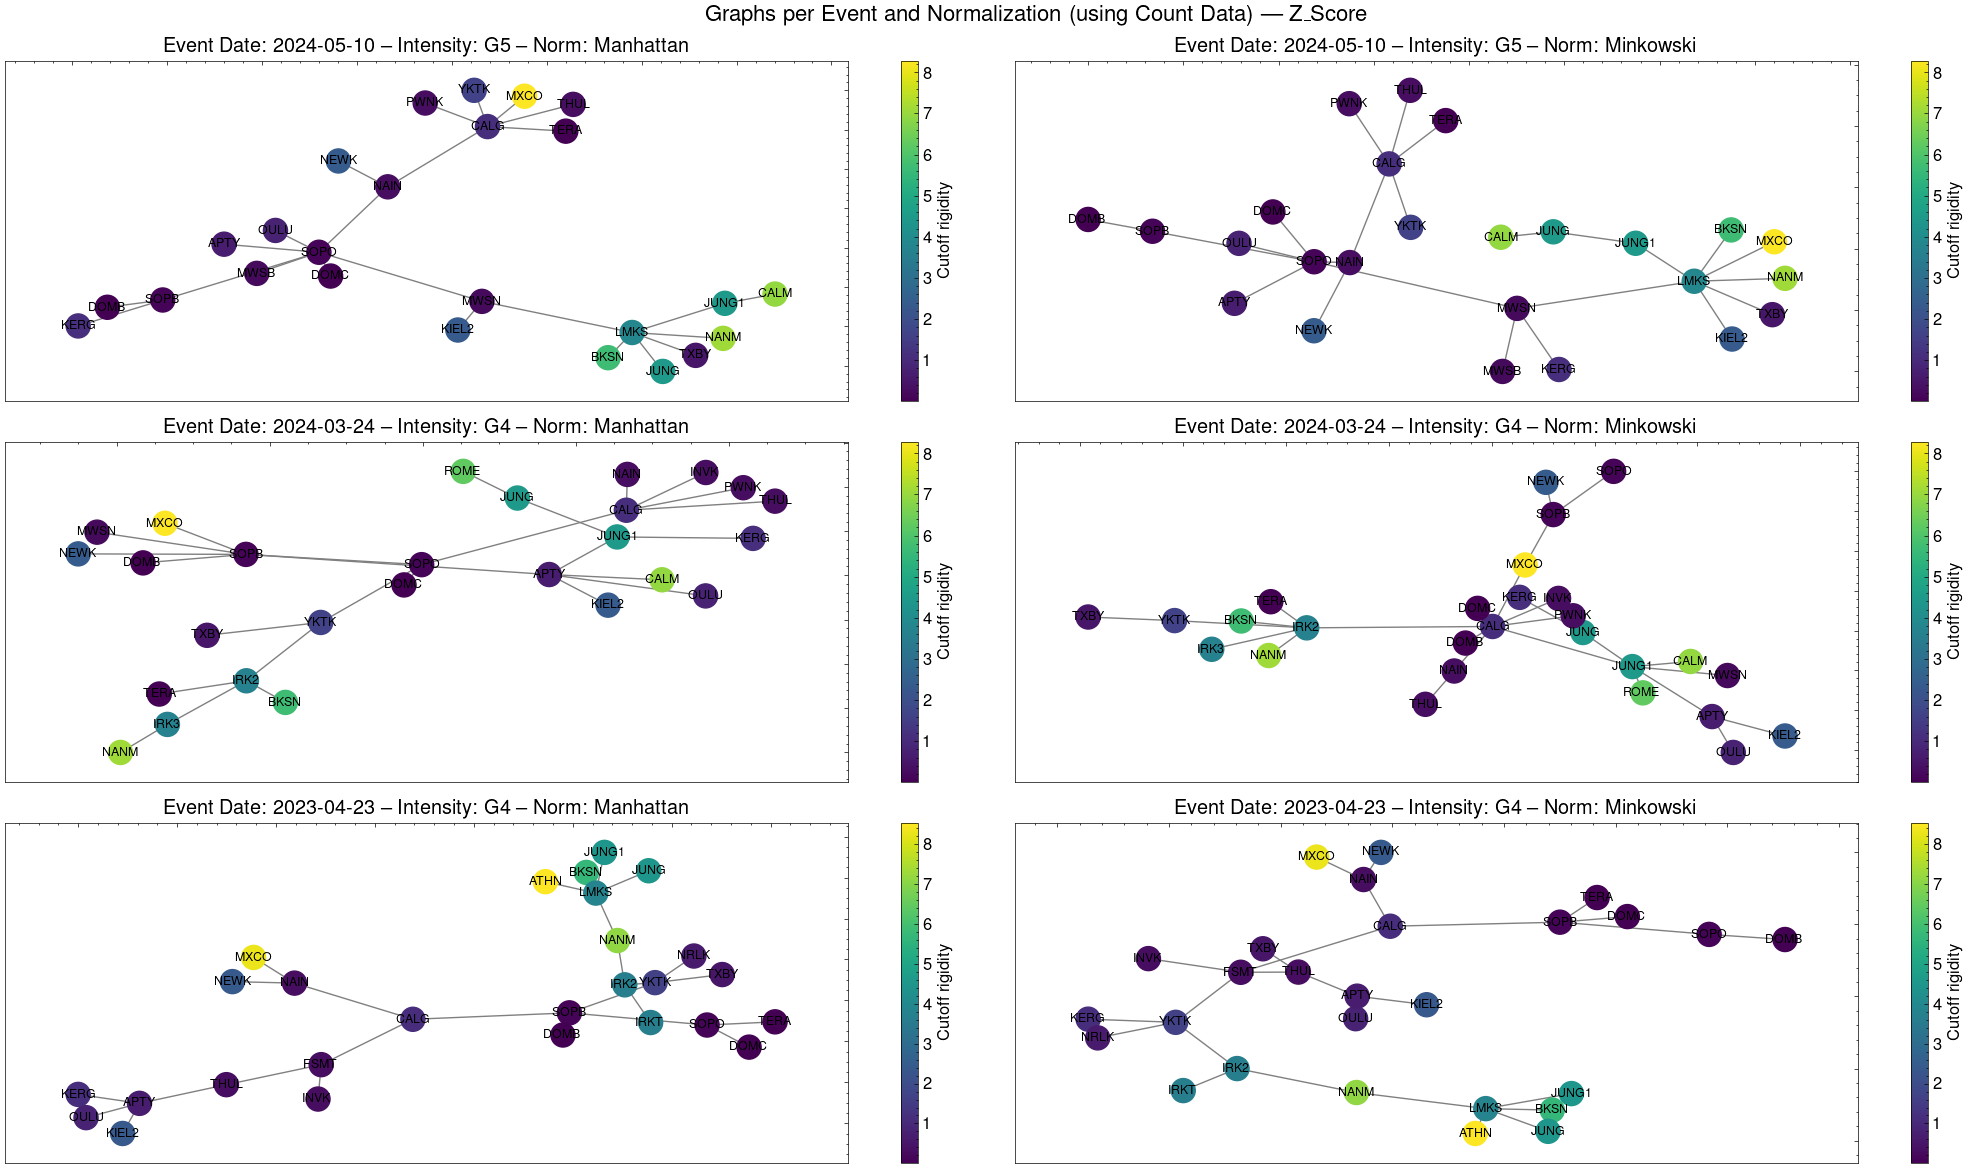

In [200]:
normalization_method = Normalizer.Z_SCORE

plot_graphs_result(
    dataset_df[(dataset_df["data_label"] == "normal") & (dataset_df["normalization"] == normalization_method.value)],
    f"Graphs per Event and Normalization (using Count Data) --- {normalization_method.value.title()}",
)

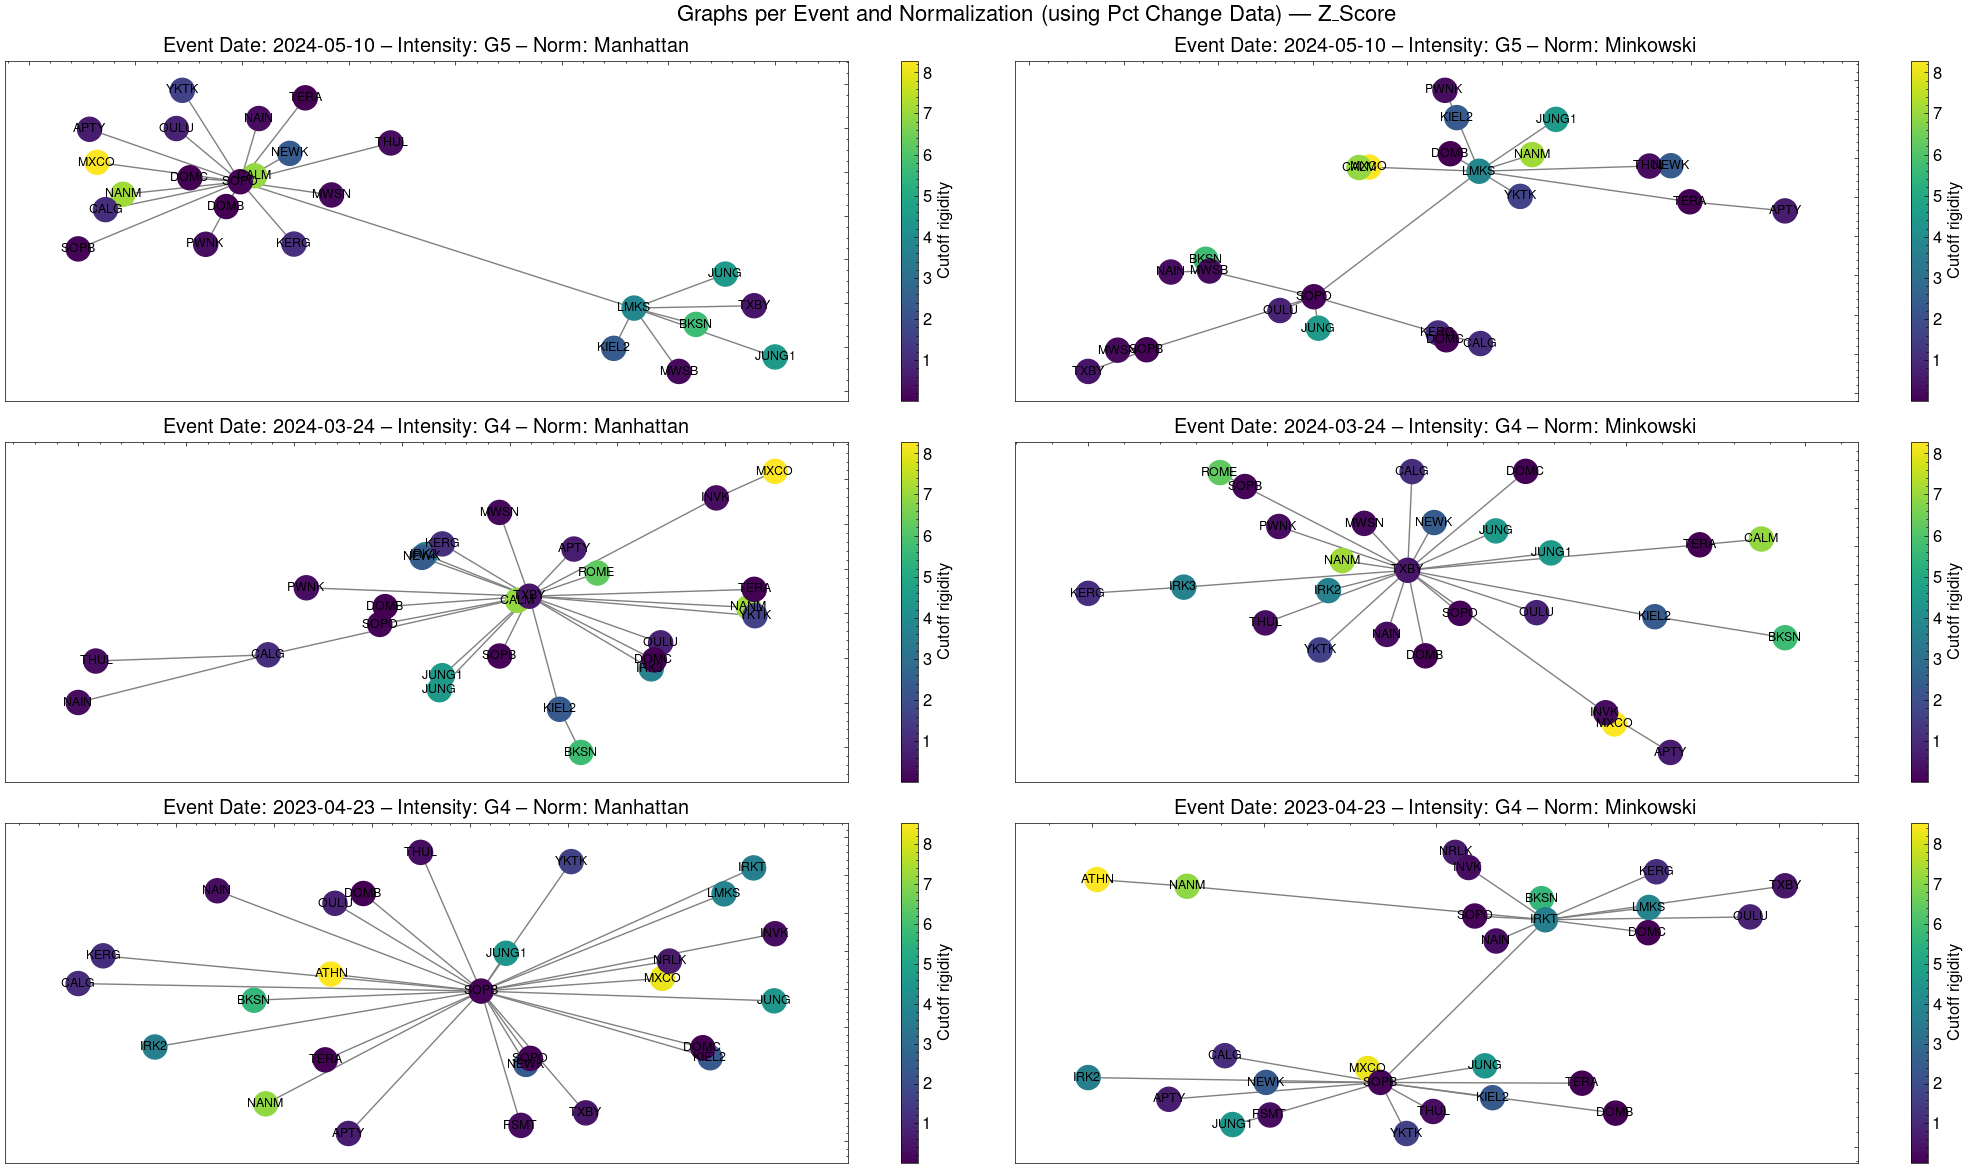

In [201]:
normalization_method = Normalizer.Z_SCORE

plot_graphs_result(
    dataset_df[(dataset_df["data_label"] == "pct_change") & (dataset_df["normalization"] == normalization_method.value)],
    f"Graphs per Event and Normalization (using Pct Change Data) --- {normalization_method.value.title()}",
)